# Solar cell at long distance

The goal of this notebook is to check the CBP transmission at different distance between the solar cell and the telescope.

In [1]:
import os, sys
print(os.path.dirname(os.getcwd()))
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits

from astropy import constants as const
from astropy import units as u

from scipy.interpolate import interp1d


from solarcell_dataset import SolarCellDataSet, SolarCellRun, calculate_npulses, get_info_from_filename, estimate_noise, get_solarcell_total_charge
%matplotlib notebook

/home/jneveu/stardice/analysis/cbp_paper


Run at short distance : the solar cell is close to the CBP on the optical table at approximately 30 cm.

In [2]:
datapath="/data/STARDICE/cbp/solarcell/ut20210730/ShortDist_5mm_2"
#datapath = "/data/STARDICE/cbp/solarcell/ut20210728/LongDist2"
nbursts = 5

run = SolarCellRun(directory_path=datapath, nbursts=nbursts)
run.load()
run.load_from_file(os.path.join(datapath, f"QSWMax_EMPTY_ShortDist_5mm_2_ntuple.npy"))
#run.load_from_file(os.path.join(datapath, f"QSWMax_LongDist2_ntuple.npy"))


100%|██████████| 140/140 [00:05<00:00, 27.09it/s]


Run at long distance : the solar cell is near the ground, on a box, at approximately 1.1 meter.

In [3]:
datapath="/data/STARDICE/cbp/solarcell/ut20210729/LongDist_5mm"

run_long = SolarCellRun(directory_path=datapath, nbursts=nbursts)
run_long.load()
run_long.load_from_file(os.path.join(datapath, f"QSWMax_LongDist_5mm_ntuple.npy"))


100%|██████████| 140/140 [00:19<00:00,  7.10it/s]


<IPython.core.display.Javascript object>


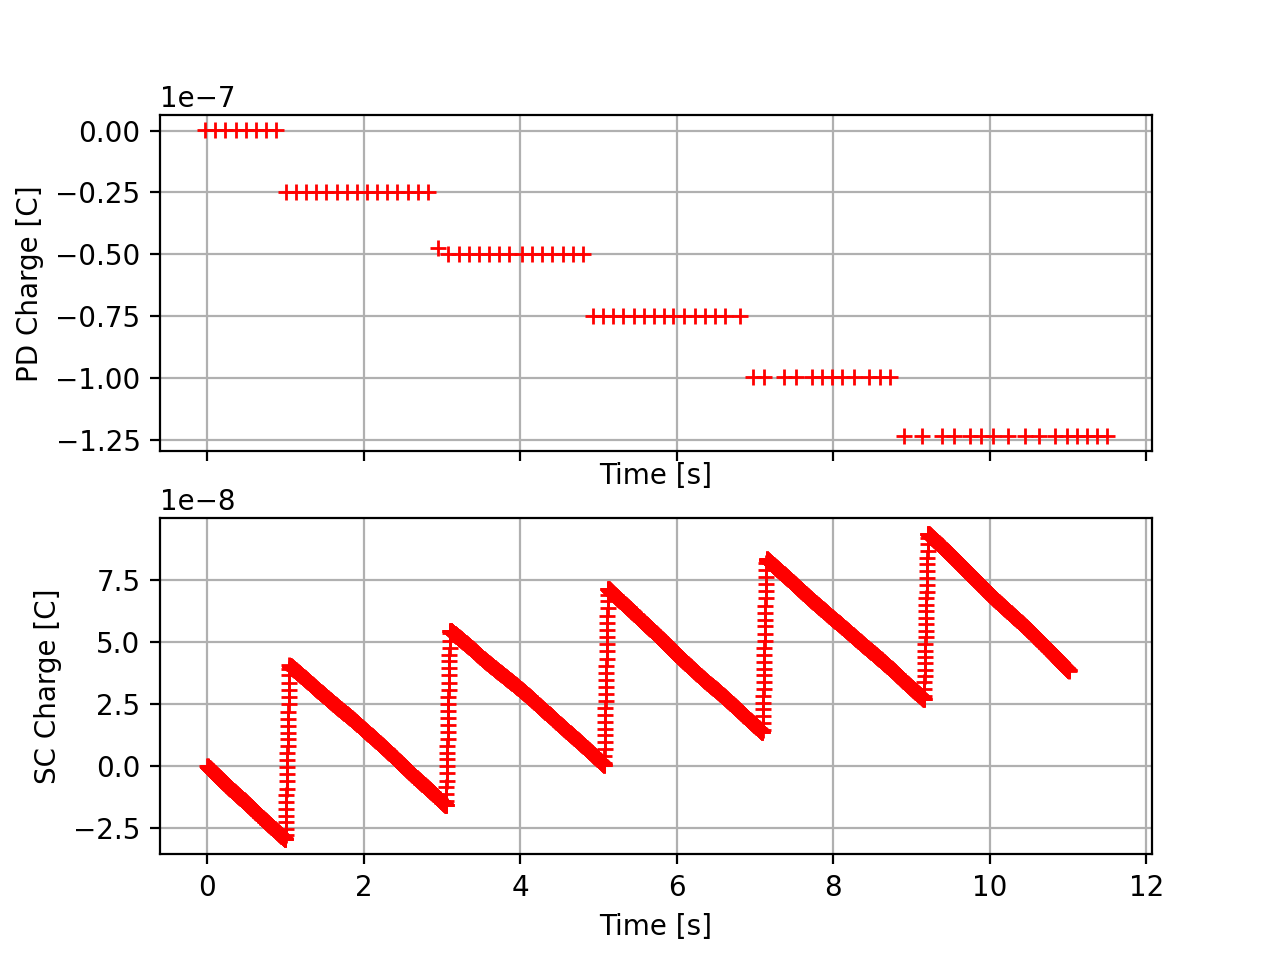

In [4]:
d = run.get_data_set(1045, 5)
d.plot_data_set()

### CBP transmissions at short and long distance

In [5]:
ref_data_root = "/data/STARDICE/cbp/solarcell/refCalData/"
SC_QE_data_file = ref_data_root + 'SC_QE_from_mono_SC_ED_20210618_MultiDay.txt'
PD_QE_data_file = ref_data_root + 'SM05PD1B_QE.csv'

SC_QE = np.loadtxt(SC_QE_data_file, skiprows=1, delimiter=",").T
PD_QE = np.loadtxt(PD_QE_data_file, skiprows=1, delimiter=",").T

# PD_QE is in A/W units, convert it to e-/photons as SC_QE
PD_QE[1] *= (const.h * const.c / (PD_QE[0] * 1e-9 * u.meter * const.e.value)).value

SC_QE_f = interp1d(SC_QE[0], SC_QE[1], bounds_error=False, fill_value=np.min(SC_QE[1]))
PD_QE_f = interp1d(PD_QE[0], PD_QE[1], bounds_error=False, fill_value=np.min(PD_QE[1]))

<IPython.core.display.Javascript object>


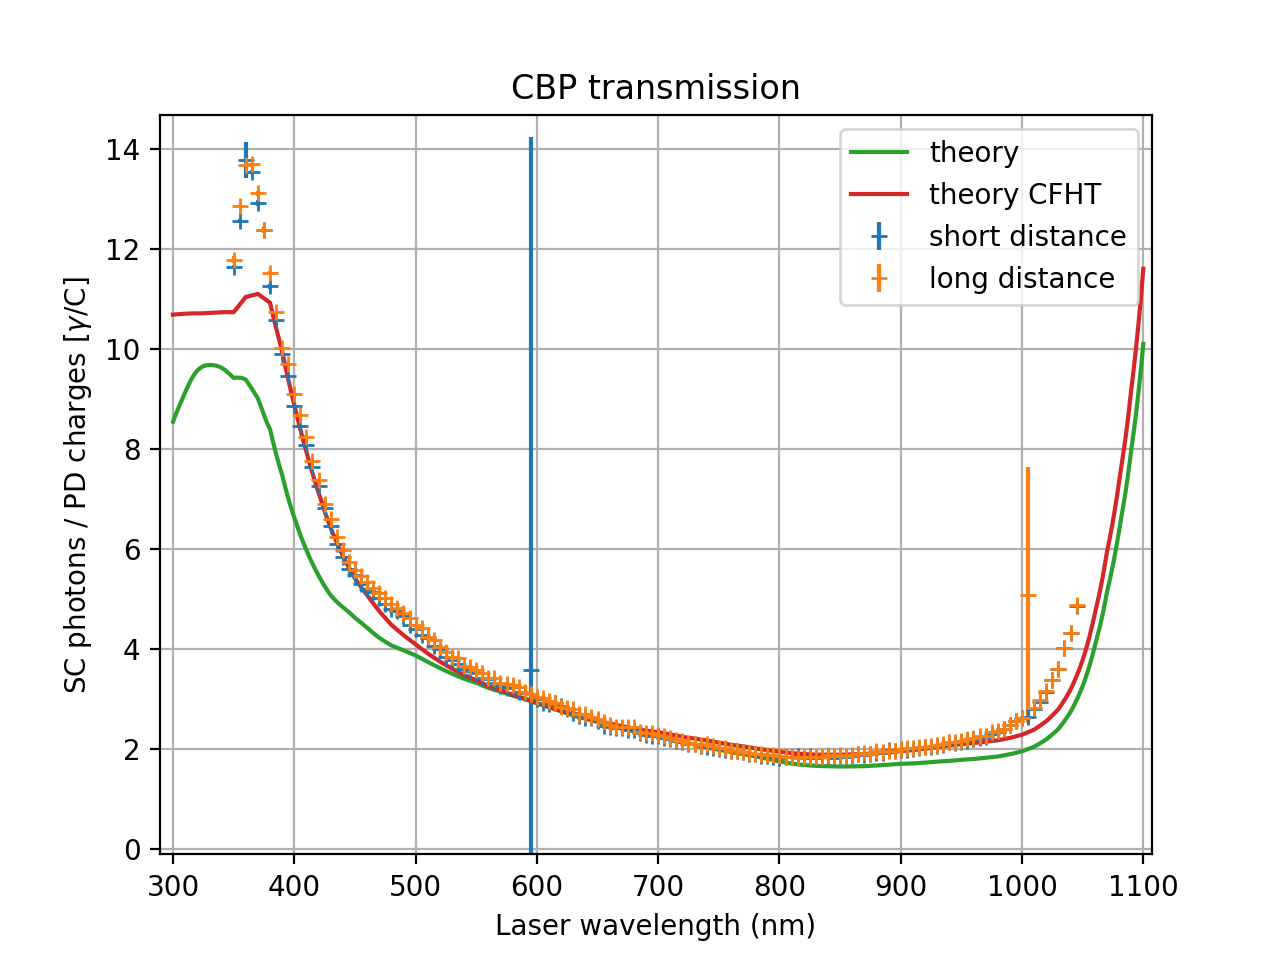

In [6]:
#tr = (run.data["sc_charge_total"] / SC_QE_f(run.data["set_wl"])) /  (-run.data["pd_charge_total"]) # / np.interp(run.data["set_wl"], PD_QE[0], PD_QE[1]))
#tr_err = tr * np.sqrt((run.data["sc_charge_total_err"]/run.data["sc_charge_total"])**2 + (run.data["pd_charge_total_err"]/run.data["pd_charge_total"])**2)

#tr_long = (run_long.data["sc_charge_total"] / SC_QE_f(run_long.data["set_wl"])) /  (-run_long.data["pd_charge_total"]) # / np.interp(run.data["set_wl"], PD_QE[0], PD_QE[1]))
#tr_long_err = tr_long * np.sqrt((run_long.data["sc_charge_total_err"]/run_long.data["sc_charge_total"])**2 + (run_long.data["pd_charge_total_err"]/run_long.data["pd_charge_total"])**2)

wl, tr, tr_err = run.get_SC_photons_over_PD_charges(plot=False)
wl, tr_long, tr_long_err = run_long.get_SC_photons_over_PD_charges(plot=False)

double_Al_wavelength, double_Al_responsivity = np.loadtxt(os.path.join(ref_data_root, 'TwoBounceAl.dat'), delimiter=',', skiprows=1).T
Al_wl, Al_CFHT = np.loadtxt(os.path.join(ref_data_root, 'CFHT_Primary_Transmission.dat'), delimiter=' ', skiprows=0).T
Al_wl *= 0.1
Al_CFHT *= Al_CFHT

fig = plt.figure()
plt.errorbar(run.data["set_wl"], tr, yerr=tr_err, marker='+', linestyle="none", label="short distance")
plt.errorbar(run_long.data["set_wl"], tr_long, yerr=tr_long_err, marker='+', linestyle="none", label="long distance")
plt.plot(double_Al_wavelength, 2*double_Al_responsivity / np.interp(double_Al_wavelength, PD_QE[0], PD_QE[1]), '-', label="theory")
plt.plot(Al_wl, 2*Al_CFHT / np.interp(Al_wl, PD_QE[0], PD_QE[1]), '-', label="theory CFHT")
plt.xlabel('Laser wavelength (nm)')
plt.ylabel('SC photons / PD charges [$\gamma$/C]')
plt.grid()
plt.title("CBP transmission")
plt.legend()
plt.show()



<IPython.core.display.Javascript object>


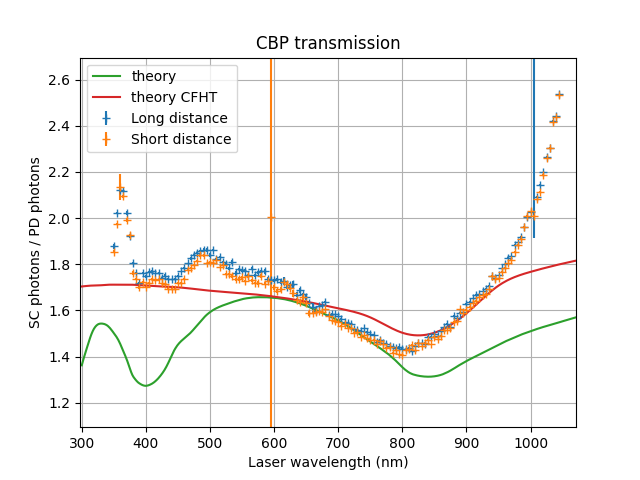

In [10]:
#tr = (run.data["sc_charge_total"] / SC_QE_f(run.data["set_wl"])) /  (-run.data["pd_charge_total"] / PD_QE_f(run.data["set_wl"]))
#tr_err = tr * np.sqrt((run.data["sc_charge_total_err"]/run.data["sc_charge_total"])**2 + (run.data["pd_charge_total_err"]/run.data["pd_charge_total"])**2)

#tr_long = (run_long.data["sc_charge_total"] / SC_QE_f(run_long.data["set_wl"])) /  (-run_long.data["pd_charge_total"] / PD_QE_f(run_long.data["set_wl"]))
#tr_long_err = tr_long * np.sqrt((run_long.data["sc_charge_total_err"]/run_long.data["sc_charge_total"])**2 + (run_long.data["pd_charge_total_err"]/run_long.data["pd_charge_total"])**2)

wl, tr, tr_err = run.get_SC_photons_over_PD_photons(plot=False)
wl, tr_long, tr_long_err = run_long.get_SC_photons_over_PD_photons(plot=False)


fig = plt.figure()
plt.errorbar(run_long.data["set_wl"], tr_long, yerr=tr_long_err, marker='+', linestyle="none", label="Long distance")
plt.errorbar(run.data["set_wl"], tr, yerr=tr_err, marker='+', linestyle="none", label="Short distance")
plt.plot(double_Al_wavelength, 2*double_Al_responsivity, '-', label="theory")
plt.plot(Al_wl, 2*Al_CFHT, '-', label="theory CFHT")
plt.xlabel('Laser wavelength (nm)')
plt.ylabel('SC photons / PD photons')
plt.title("CBP transmission")
plt.grid()
plt.legend()
plt.show()


<IPython.core.display.Javascript object>


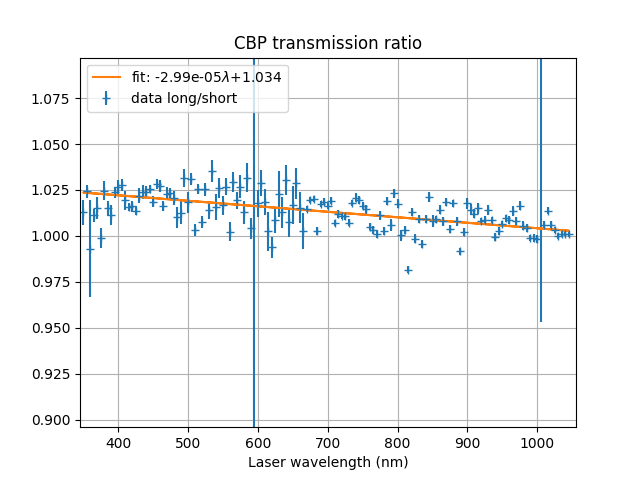

In [8]:
ratio = tr_long/tr
ratio_err = ratio * np.sqrt( (tr_err/tr)**2 + (tr_long_err/tr_long)**2)
pval = np.polyfit(run_long.data["set_wl"], ratio, deg=1, w=1/ratio_err)

fig = plt.figure()
plt.errorbar(run_long.data["set_wl"], ratio, yerr = ratio_err, linestyle="none", marker="+", label="data long/short")
plt.plot(run_long.data["set_wl"], np.polyval(pval, run_long.data["set_wl"]), label=f"fit: {pval[0]:.3g}$\lambda$+{pval[1]:.3f}")
plt.title("CBP transmission ratio")
plt.grid()
plt.xlabel('Laser wavelength (nm)')
plt.legend()
#plt.ylim(pval[1]-0.1, pval[1]+0.1)
plt.show()

## Checks

In [ ]:
d = run.get_data_set(800, 5)
d_long = run_long.get_data_set(800, 5)

In [ ]:
d.plot_data_set()

In [ ]:
d_long.plot_data_set()

In [ ]:
fig = plt.figure()
plt.errorbar(run.data["set_wl"], run.data["pd_charge_total"], yerr=run.data["pd_charge_total_err"], label="Short", linestyle="none", marker="+")
plt.errorbar(run_long.data["set_wl"], run_long.data["pd_charge_total"], yerr=run_long.data["pd_charge_total_err"], label="Long", linestyle="none", marker="+")
plt.grid()
plt.legend()
plt.show()

In [ ]:
fig = plt.figure()
plt.errorbar(run.data["set_wl"], run_long.data["pd_charge_total"]/run.data["pd_charge_total"], yerr=run.data["pd_charge_total_err"], label="Short", linestyle="none", marker="+")
#plt.errorbar(run_long.data["set_wl"], run_long.data["pd_charge_total"], yerr=run_long.data["pd_charge_total_err"], label="Long", linestyle="none", marker="+")
plt.grid()
plt.legend()
plt.show()

In [ ]:
fig = plt.figure()
plt.errorbar(run.data["set_wl"], run.data["sc_charge_total"], yerr=run.data["sc_charge_total_err"], label="Short", linestyle="none", marker="+")
plt.errorbar(run_long.data["set_wl"], run_long.data["sc_charge_total"], yerr=run_long.data["sc_charge_total_err"], label="Long", linestyle="none", marker="+")
plt.grid()
plt.legend()
plt.show()

In [ ]:
fig = plt.figure()
plt.errorbar(run.data["set_wl"], run_long.data["sc_charge_total"]/(run.data["sc_charge_total"]), yerr=run.data["sc_charge_total_err"], label="Short", linestyle="none", marker="+")
#plt.errorbar(run_long.data["set_wl"], run_long.data["sc_charge_total"], yerr=run_long.data["sc_charge_total_err"], label="Long", linestyle="none", marker="+")
plt.grid()
plt.legend()
plt.show()